In [10]:
DATASET_VERSION = 'v1.02-train'
DATASET_ROOT = '/home/ezhang/lyft/v1.02-train/v1.02-train'
ARTIFACTS_FOLDER = "/home/ezhang/lyft/artifacts-2"

import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
from tqdm import tqdm, tqdm_notebook

from lyft_dataset_sdk.lyftdataset import LyftDataset

In [11]:
level5data = LyftDataset(json_path=DATASET_ROOT + "/v1.02-train", data_path=DATASET_ROOT)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
15991 instance,
8 sensor,
128 calibrated_sensor,
149072 ego_pose,
148 log,
148 scene,
18634 sample,
149072 sample_data,
539765 sample_annotation,
1 map,
Done loading in 6.0 seconds.
Reverse indexing ...
Done reverse indexing in 1.8 seconds.


In [12]:
# Preprocessing. Most of these are taken from lyft's dataset tutorials.

def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))

    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size, z_offset):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
        
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

def move_boxes_to_car_space(boxes, ego_pose):
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    for box in boxes:
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, z_offset=0.0):
    for box in boxes:
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        # Drop z coordinate (to get 2d)
        corners_voxel = corners_voxel[:,:2]

        # Objects will have class value 1
        class_value = 1

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_value, class_value, class_value), -1)

In [13]:
# Generate the training/testing data

voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

box_scale = 0.8

train_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

NUM_WORKERS = os.cpu_count()

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token
    
input_filepaths = glob.glob(os.path.join(train_data_folder, "*_input.png"))
target_filepaths = glob.glob(os.path.join(train_data_folder, "*_target.png"))
map_filepaths = glob.glob(os.path.join(train_data_folder, "*_map.png"))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False):
        super().__init__()
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2 ** (wf + i), padding))
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2 ** (wf + i), padding))
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding):
        super().__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        block.append(nn.Dropout(0.5))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        block.append(nn.Dropout(0.5))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, padding):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2), nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [16]:
def get_unet_model(in_channels=6, num_output_classes=2):
    model = UNet(in_channels=6, n_classes=num_output_classes, wf=5, depth=4, padding=True)
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model

def visualize_predictions(input_image, prediction, target, n_images=2):
    # Only select the first n images
    prediction = prediction[:n_images]
    target = target[:n_images]
    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    class_one_preds = np.hstack(1-prediction[:,0])

    target = np.hstack(target.detach().cpu().numpy())

    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0
    class_rgb[...,1] = target
    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
    overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [ ]:
device = torch.device('cuda')
batch_size = 8
epochs = 500

model = get_unet_model(num_output_classes = 2)
model = model.to(device)

optim = torch.optim.Adam(model.parameters())
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

input_filepaths = glob.glob(os.path.join(validation_data_folder, "*_input.png"))[:500]
target_filepaths = glob.glob(os.path.join(validation_data_folder, "*_target.png"))[:500]
map_filepaths = glob.glob(os.path.join(validation_data_folder, "*_map.png"))[:500]
validation_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())

all_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    
    epoch_losses = []
    progress_bar = tqdm_notebook(dataloader)
    model.train()
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

        if ii == 0:
            visualize_predictions(X, prediction, target) 
    
    print("Train Loss:", np.mean(epoch_losses))
    all_losses.append(np.mean(epoch_losses))
    
    with torch.no_grad():
        model.eval()
        epoch_losses = []
        progress_bar = tqdm_notebook(val_dataloader)
        for ii, (X, target, sample_ids) in enumerate(progress_bar):
            X = X.to(device)  # [N, 3, H, W]
            target = target.to(device)  # [N, H, W] with class indices (0, 1)
            prediction = model(X)  # [N, 2, H, W]
            #loss = F.cross_entropy(prediction, target, weight=class_weights)
            loss = F.cross_entropy(prediction, target)

            epoch_losses.append(loss.detach().cpu().numpy())

        print("Validation Loss:", np.mean(epoch_losses))
        val_losses.append(np.mean(epoch_losses))

    checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch)
    checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_filepath)
    
    if epoch % 10 == 0:
        plt.figure(figsize=(12,12))
        plt.plot(all_losses, alpha=0.75, label="train loss")
        plt.plot(val_losses, alpha=0.75, label="val loss")
        plt.show()
    
plt.figure(figsize=(12,12))
plt.plot(all_losses, alpha=0.75, label="train loss")
plt.plot(val_losses, alpha=0.75, label="val loss")
plt.show()

In [24]:
input_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_input.png")))[:500]
target_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_target.png")))[:500]
map_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_map.png")))[:500]

batch_size=1
validation_dataset = BEVImageDataset(input_filepaths, target_filepaths, map_filepaths)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())


device = torch.device('cuda')
model = get_unet_model(num_output_classes=2)
model = model.to(device)

epoch_to_load=180
checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join(ARTIFACTS_FOLDER, checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_filepath))

<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


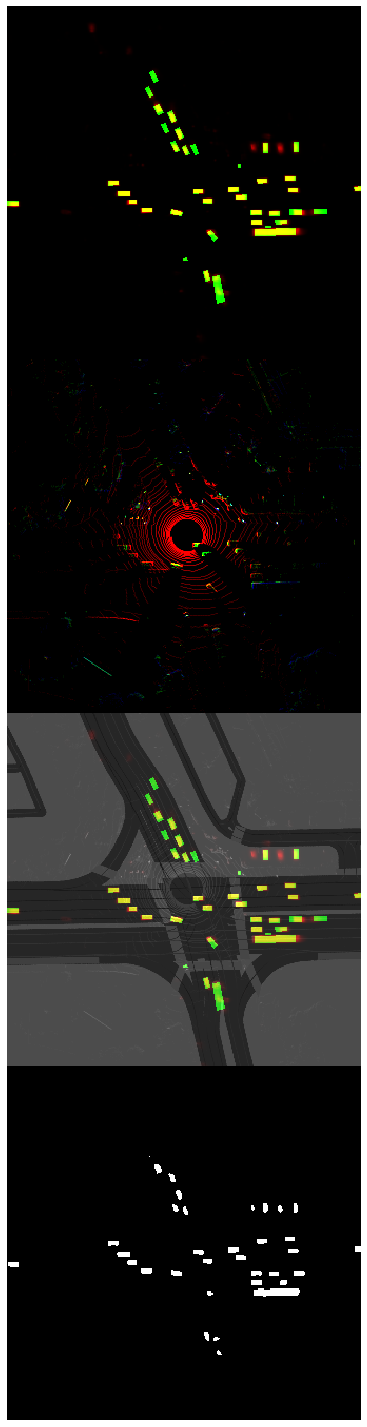

KeyboardInterrupt: 

<Figure size 864x1872 with 0 Axes>

In [33]:
import time

progress_bar = tqdm_notebook(validation_dataloader)

targets = np.zeros((len(target_filepaths), 336, 336), dtype=np.uint8)

predictions = np.zeros((len(target_filepaths), 2, 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

times = []

with torch.no_grad():
    model.eval()
    for ii, (X, target, batch_sample_tokens) in enumerate(progress_bar):

        start = time.time()
        
        offset = ii*batch_size
        targets[offset:offset+batch_size] = target.numpy()
        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target)
        all_losses.append(loss.detach().cpu().numpy())
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions[offset:offset+batch_size] = np.round(prediction_cpu*255).astype(np.uint8)
        
        elapsed = time.time() - start
        times.append(elapsed)
        
        # Visualize the first prediction
        if ii % 100 == 0:
            visualize_predictions(X, prediction, target)
            
print("Mean loss:", np.mean(all_losses))
print("Avg time:", np.mean(times))

fig = plt.figure(figsize=(12,12))
fig.suptitle("Inference time per frame (in seconds)")
fig.tight_layout()
plt.plot(times)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


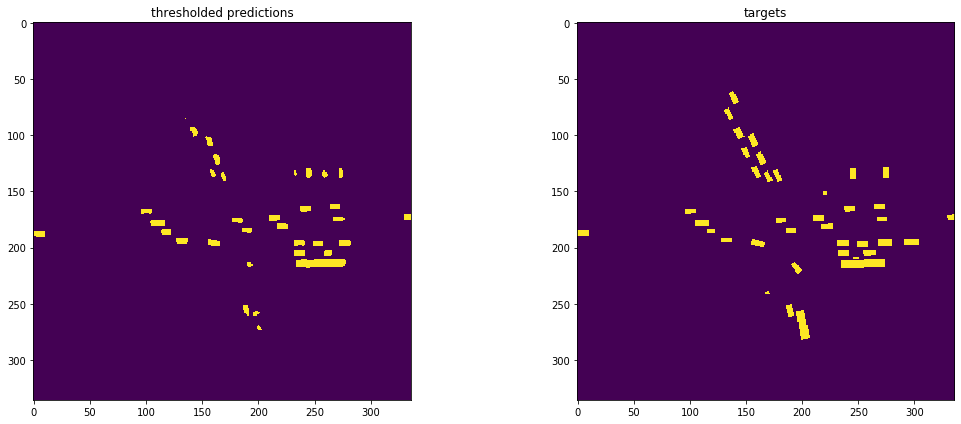

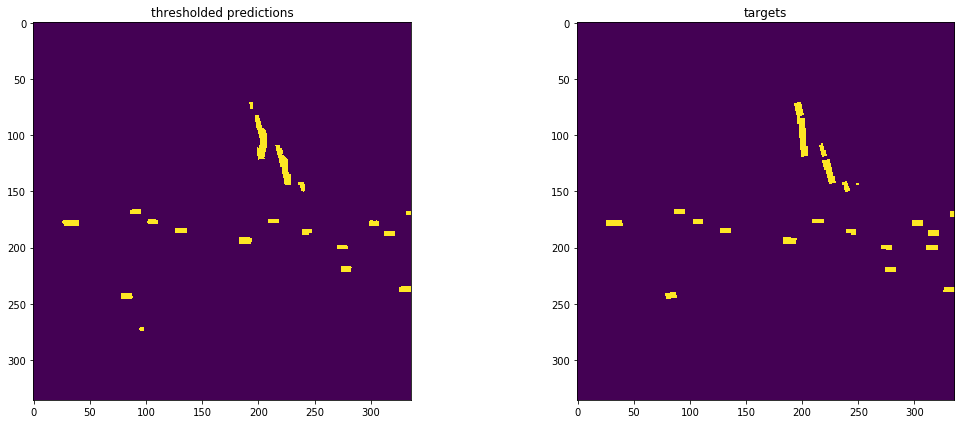

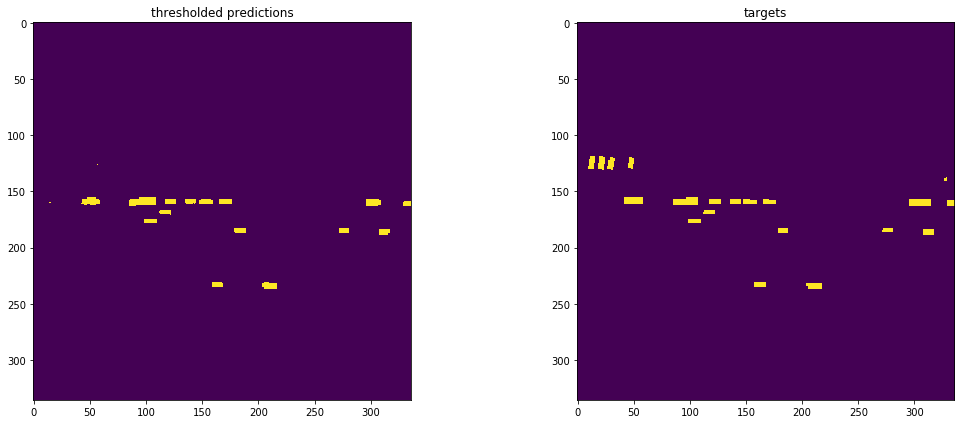

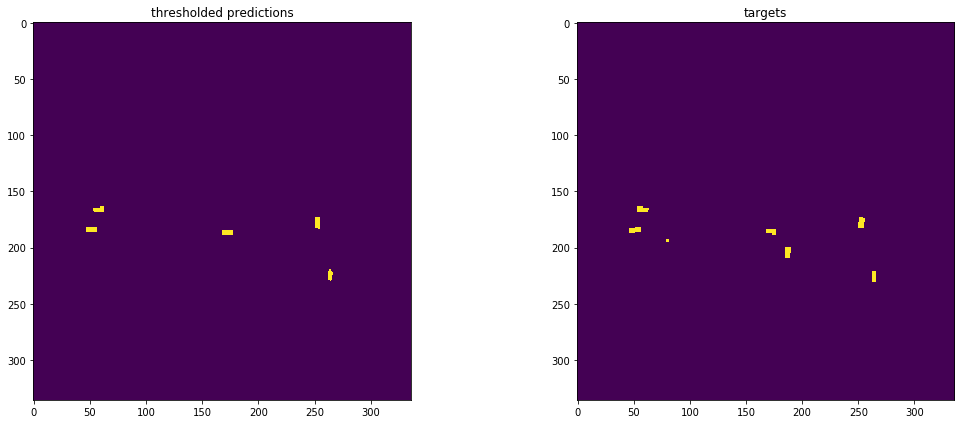

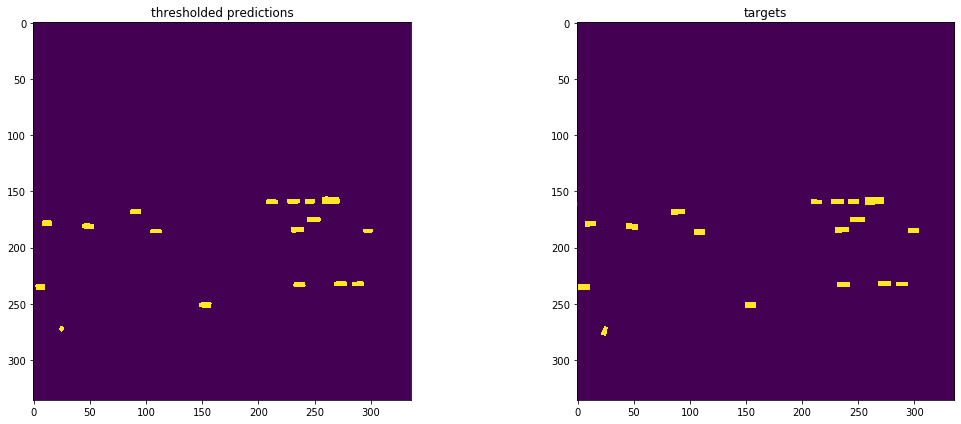

In [34]:
predictions = 255 - predictions[:,0]
N = 5
for i in range(N):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    axes[0].imshow(predictions[i] > 255//2)
    axes[0].set_title("thresholded predictions")
    axes[1].imshow((targets[i] > 0).astype(np.uint8), interpolation="nearest")
    axes[1].set_title("targets")
    fig.tight_layout()    
    fig.show()

100%|██████████| 500/500 [00:00<00:00, 8101.90it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


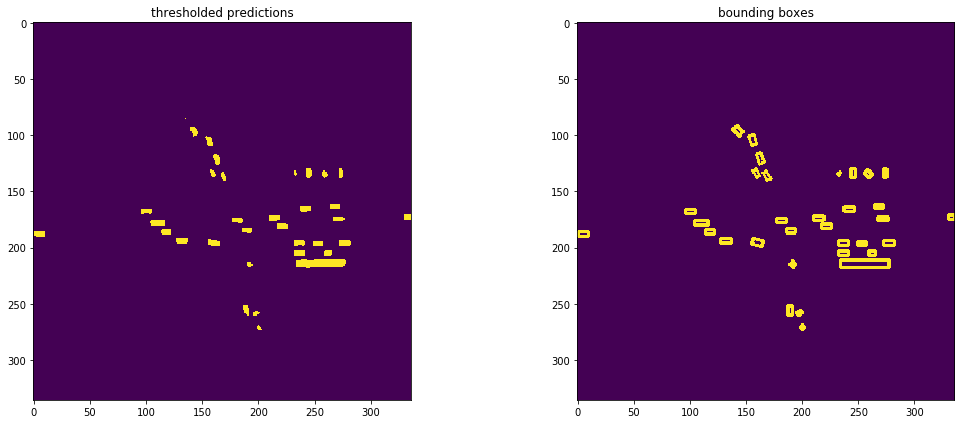

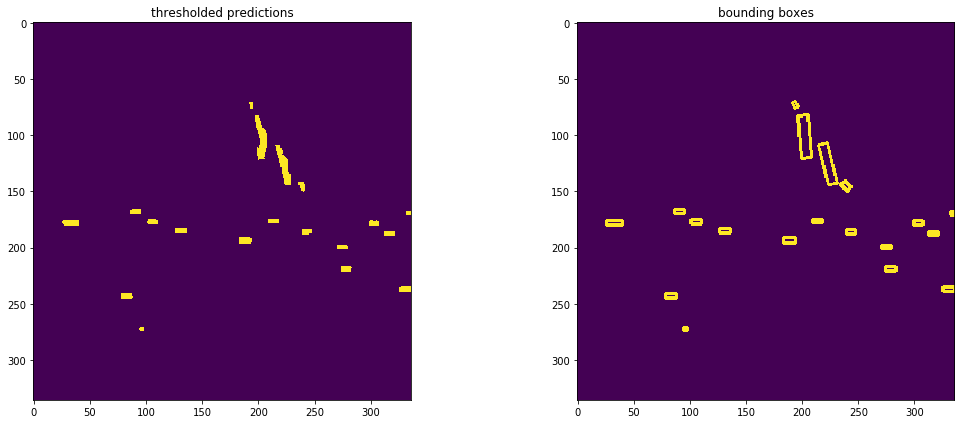

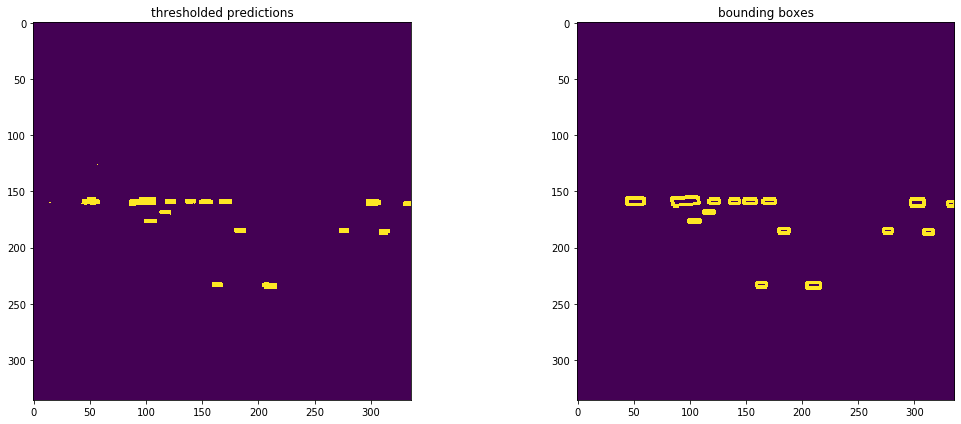

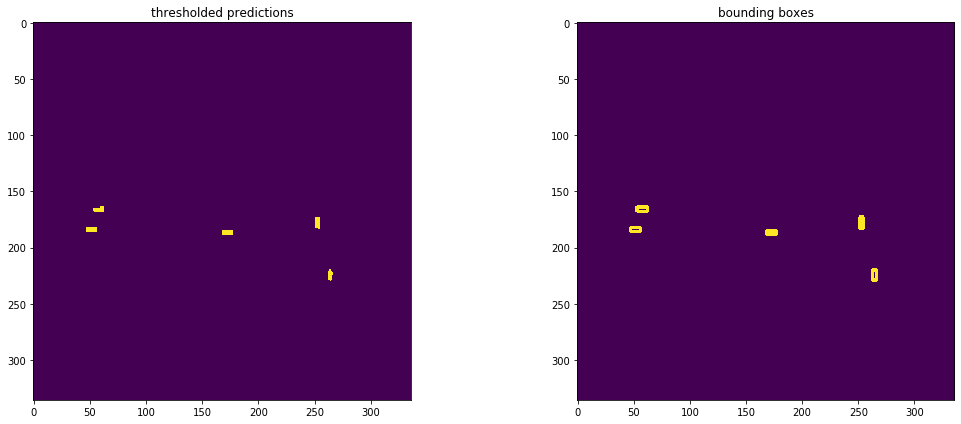

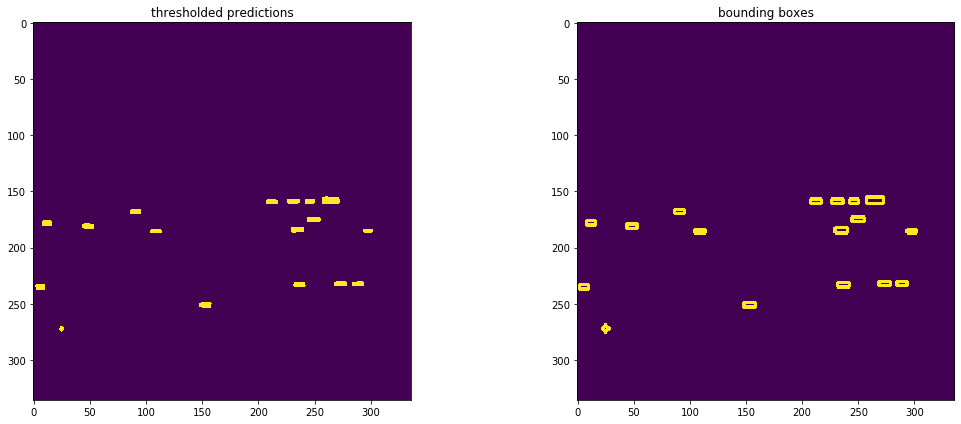

In [45]:
# Filter noise:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#opening
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
predictions_opened = np.zeros((predictions.shape), dtype=np.uint8)

for i, p in enumerate(tqdm(predictions)):
    thresholded_p = (p > 255//2).astype(np.uint8)
    predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)

# Find bounding boxes
detection_boxes = []
for i in tqdm_notebook(range(len(predictions))):
    prediction = predictions_opened[i]
    sample_boxes = []
    
    contours, hierarchy = cv2.findContours(prediction, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        sample_boxes.append(box)
        
    detection_boxes.append(np.array(sample_boxes))
    
for i in range(N):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    axes[0].imshow(predictions[i] > 255//2)
    axes[0].set_title("thresholded predictions")
    t = np.zeros_like(predictions[i])
    for sample_boxes in detection_boxes[i]:
        box_pix = np.int0(sample_boxes)
        cv2.drawContours(t,[box_pix],0,(255),2)
    axes[1].imshow(t)
    axes[1].set_title("bounding boxes")
    fig.tight_layout()    
    fig.show()